# KDE smoothing using seaborn

In [1]:
# import libraries
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# import dataset
df = sns.load_dataset('iris')

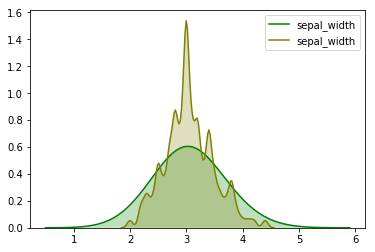

In [3]:
# Large bandwidth
sns.kdeplot(df['sepal_width'], shade=True, bw=.5, color="green")
#plt.show()
 
# Narrower bandwidth
sns.kdeplot(df['sepal_width'], shade=True, bw=.05, color="olive")
#sns.plt.show()

In [4]:
df.head()

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


In [5]:
df.tail()

,sepal_length,sepal_width,petal_length,petal_width,species
145,6.7,3.0,5.2,2.3,virginica
146,6.3,2.5,5.0,1.9,virginica
147,6.5,3.0,5.2,2.0,virginica
148,6.2,3.4,5.4,2.3,virginica
149,5.9,3.0,5.1,1.8,virginica


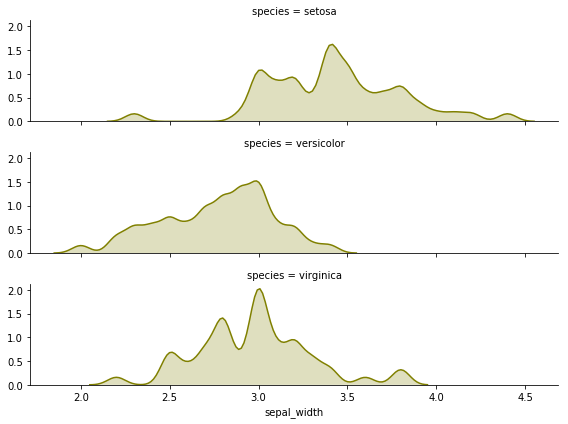

In [6]:
g = sns.FacetGrid(df, row='species', height=2, aspect=4,)
g.map(sns.kdeplot, 'sepal_width', shade=True, bw=.05, color="olive")
plt.show()

In [7]:
locations = np.arange(0,10,1)

In [8]:
data = {}
for loc in locations:
    orientations = np.random.random(size=25)
    orientations *= 180
    data[loc] = orientations

In [9]:
df_fracs = pd.DataFrame(data)
df_fracs.head()

,0,1,2,3,4,5,6,7,8,9
0,168.008091,86.631911,54.839944,98.548297,121.023950,40.454627,118.719410,169.169353,52.773453,24.678400
1,32.092915,167.062882,84.683681,103.489376,18.609799,109.826840,92.264234,24.981189,160.249041,30.119931
2,86.710520,106.276704,165.586991,90.721775,5.442732,174.827579,15.983327,156.249922,81.818705,31.601861
3,53.928812,160.943088,51.287949,93.818133,122.271319,134.896005,150.192178,167.295444,105.177835,71.647593
4,84.143067,76.027776,98.639208,46.997145,140.304357,20.966196,102.390809,60.662876,171.635073,118.478725


In [10]:
df_fracs = df_fracs.melt()
df_fracs.head()

,variable,value
0,0,168.008091
1,0,32.092915
2,0,86.710520
3,0,53.928812
4,0,84.143067


In [11]:
df_fracs.variable.unique()

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [12]:
def plot_frac_azis(df, start_location=df.index.min(), end_location=df.index.max(), cmap='viridis'):
    """
    plot fracture azimuths for a range of locations between start_location and end_location
    by default all data are plotted
    args:
        dataframe, selection of locations from dataframe as a list of indexes
    returns:
        FacetGrid plot
        
    TODO:
        - find a symmetrical colormap to better represent azimuths
        - fix the label and title sizes
    """
    # slice into Dataframe
    df_fracs = df.iloc[np.where((df['variable'] >= start_location) &
                                (df['variable'] <= end_location))]
    
    # define the plot labels
    labels = df_fracs.variable.unique()
    
    # set up the FacetGrid with a given color map
    g2 = sns.FacetGrid(df_fracs, row='variable', height=2, aspect=12, palette=cmap, hue='value')
    
    # map the sns.kdeplot onto the FacetGrid and set up plot axes
    g2.map(sns.kdeplot, 'value', shade=True, bw=0.5)
    g2.despine(top=True, right=True, left=False, bottom=False)
    g2.set_axis_labels(x_var='Fracture azimuth')
    axes = g2.axes.flatten()
    for ax in enumerate(axes):
        ax[1].set_ylabel(labels[ax[0]])
    plt.subplots_adjust(top=0.85)
    g2.fig.suptitle('Fracture orientations by locations')
    g2.set_titles(row_template='')
    
    return plt.show()

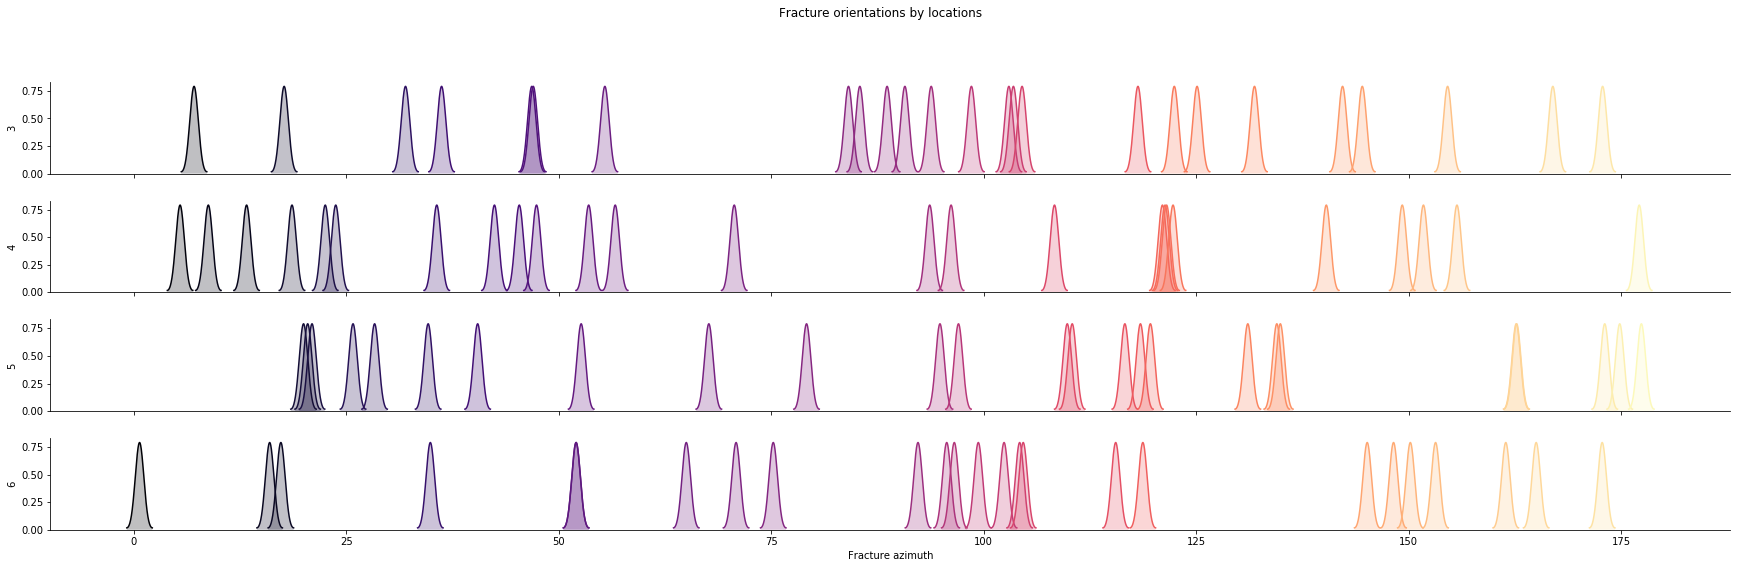

In [13]:
plot_frac_azis(df_fracs, start_location=3, end_location=6, cmap='magma')

<hr />

<div>
<img src="https://avatars1.githubusercontent.com/u/1692321?s=50"><p style="text-align:center">© Agile Geoscience 2019</p>
</div>